## Conditional GAN for EQ Response Spectra Prediction

Uses 6 inputs (parameters related to the Earthquake) to generate 20 outputs (of the Response Spectrum)

Response Spectrum of an Earthquake gives the Frequency-Domain signal of the accelerations faced by structures.

## 1. Load Libraries
Load libraries and set the device on which computations will take place

In [42]:
# Importing all necessary libraries
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random

from IPython.display import clear_output
# To help with readability by reducing unnecessary output
import os

In [5]:
# Run this if you have an Nvidia GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [6]:
# Run this if it's a macbook
device = "mps" if torch.backends.mps.is_available() else "cpu"
# device='cpu'
print(f"Device: {device}")

Device: mps


In [7]:
# Paths for mat files with the real data
input_path = "../data/processed_accelerations"
output_path = "../output/generated_accelerations"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2. Load Data
Load pre-processed data

In [43]:
os.makedirs("../models/intermediate", exist_ok=True)
CGAN_GENERATOR_PATH = (
    "../models/intermediate/CGAN_g_model.hdf5"
)
CGAN_DISCRIMINATOR_PATH = (
    "../models/intermediate/CGAN_d_model.hdf5"
)

os.makedirs("../output", exist_ok=True)

res = "../output/results.csv"

In [9]:
X_train = np.load(input_path + "/X_train.npy")
X_test = np.load(input_path + "/X_test.npy")
y_train = np.load(input_path + "/y_train.npy")
y_test = np.load(input_path + "/y_test.npy")

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (6834, 6)
Shape of X_test: (1709, 6)
Shape of y_train: (6834, 56)
Shape of y_test: (1709, 56)


In [10]:
train_data = pd.DataFrame(X_train)
train_labels = pd.DataFrame(y_train).abs()
test_data = pd.DataFrame(X_test)
test_labels = pd.DataFrame(y_test).abs()   

## 3. Analyze and Transform Data

In [11]:
print("Min values:\n", train_labels.min())
print("Max values:\n", train_labels.max())

Min values:
 0     0.000300
1     0.000322
2     0.000188
3     0.000297
4     0.000700
5     0.000457
6     0.000521
7     0.001084
8     0.000393
9     0.000251
10    0.000317
11    0.000032
12    0.000818
13    0.000131
14    0.000262
15    0.000942
16    0.000183
17    0.001782
18    0.000571
19    0.000364
20    0.000513
21    0.000130
22    0.000519
23    0.000002
24    0.000713
25    0.000089
26    0.000318
27    0.000577
28    0.000145
29    0.000532
30    0.000072
31    0.000218
32    0.000602
33    0.000032
34    0.000782
35    0.000141
36    0.000505
37    0.000360
38    0.000346
39    0.000238
40    0.000358
41    0.001447
42    0.001692
43    0.005634
44    0.000308
45    0.000886
46    0.003672
47    0.020990
48    0.047008
49    0.003271
50    0.156840
51    0.333274
52    0.912891
53    1.074316
54    0.891233
55    1.095380
dtype: float64
Max values:
 0     13.027053
1     13.326931
2     11.242898
3      9.963238
4      9.495359
5      8.604905
6      8.241738
7      

Scale data to be normally distributed. Neural Networks work well with normally distributed data

In [12]:
scaler = StandardScaler()
normalized_df = pd.DataFrame(
    scaler.fit_transform(train_data), columns=train_data.columns
)
normalized_df_test = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

In [13]:
normalized_df # Final normalized inputs

,0,1,2,3,4,5
0,2.203633,-0.340146,0.058512,0.274330,-0.595797,-0.832253
1,-0.278873,-0.912651,-0.709737,-1.125082,-0.620380,1.625929
2,-0.402999,1.054751,0.939378,0.125708,0.326064,-0.217708
3,-0.527124,-0.797031,-0.505601,-0.648285,-0.362259,-0.832253
4,-0.402999,1.343800,1.058441,0.489071,-0.128721,-0.832253
...,...,...,...,...,...,...
6829,0.093503,1.026778,0.927143,-1.450028,-0.288510,0.396838
6830,-0.899500,0.463598,0.646623,-0.088923,-0.153304,-0.832253
6831,-0.899500,2.138221,1.331786,1.371840,-0.522048,-0.832253
6832,-0.154748,-0.345741,0.053091,-0.831141,-1.112039,-0.217708


Need to find out the mean and standard deviation of each input variable to generate a conditional distribution for the CGAN

In [14]:
cond = []

### 3.1 Visualize and Extract Data

-1.559575802809702e-17
1.0000000000000122


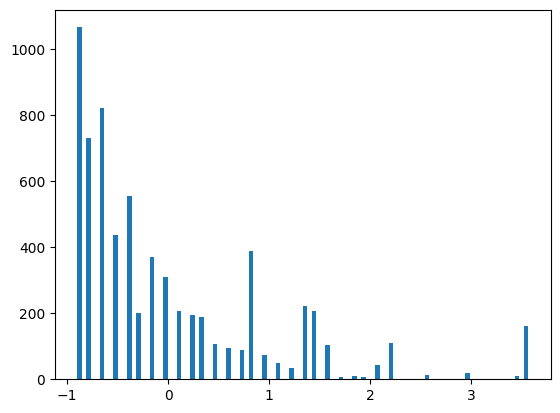

In [15]:
# Distribution of the first column
plt.hist(normalized_df[0], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[0]))
print(np.std(normalized_df[0]))
cond.append((np.mean(normalized_df[0]), np.std(normalized_df[0])))

5.198586009365673e-18
0.9999999999999983


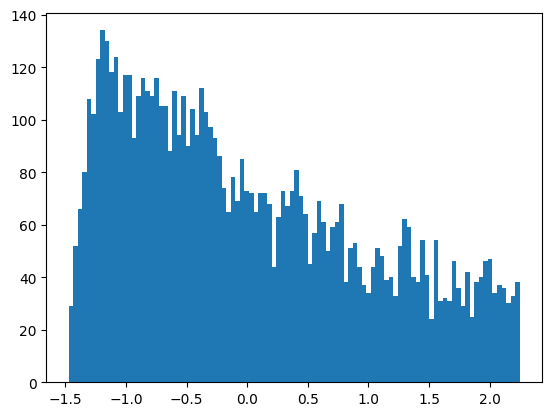

In [16]:
# Distribution of the second column
plt.hist(normalized_df[1], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[1]))
print(np.std(normalized_df[1]))
cond.append((np.mean(normalized_df[1]), np.std(normalized_df[1])))

1.0397172018731346e-18
1.0000000000000002


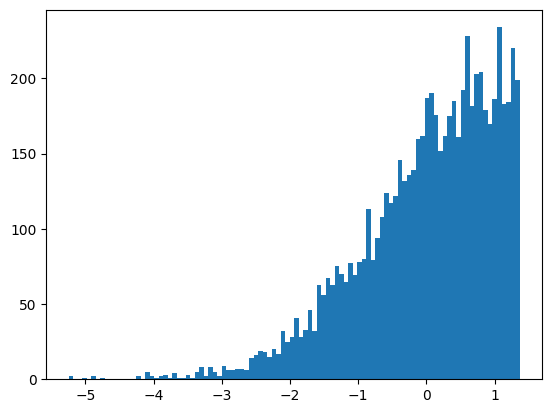

In [17]:
# Distribution of the third column
plt.hist(normalized_df[2], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[2]))
print(np.std(normalized_df[2]))
cond.append((np.mean(normalized_df[2]), np.std(normalized_df[2])))

-4.262840527679852e-17
1.000000000000002


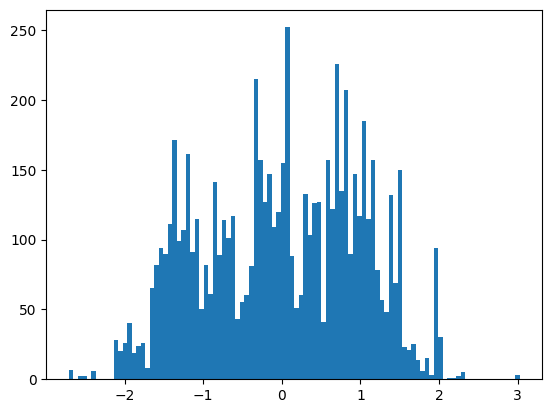

In [18]:
# Distribution of the fourth column
plt.hist(normalized_df[3], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[3]))
print(np.std(normalized_df[3]))
cond.append((np.mean(normalized_df[3]), np.std(normalized_df[3])))

-4.678727408429106e-17
0.999999999999998


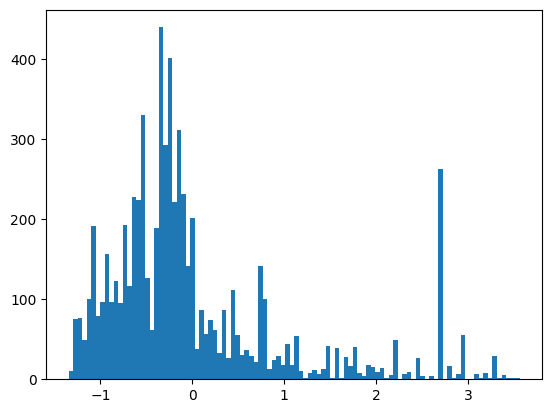

In [19]:
# Distribution of the fourth column
plt.hist(normalized_df[4], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[4]))
print(np.std(normalized_df[4]))
cond.append((np.mean(normalized_df[4]), np.std(normalized_df[4])))

-5.198586009365673e-19
0.9999999999999782


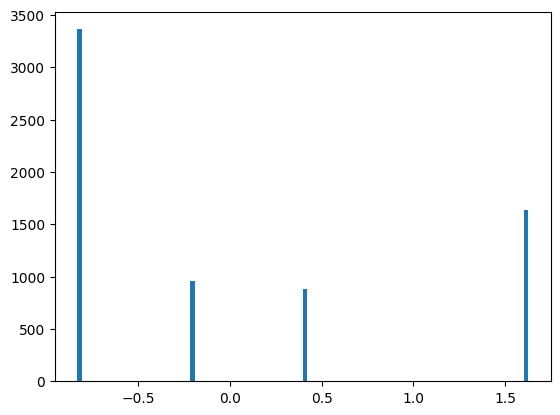

In [20]:

# Distribution of the fifth column
plt.hist(normalized_df[5], bins=100)
clear_output(wait=True)
print(np.mean(normalized_df[5]))
print(np.std(normalized_df[5]))
cond.append((np.mean(normalized_df[5]), np.std(normalized_df[5])))

In [21]:
cond

[(np.float64(-1.559575802809702e-17), np.float64(1.0000000000000122)),
 (np.float64(5.198586009365673e-18), np.float64(0.9999999999999983)),
 (np.float64(1.0397172018731346e-18), np.float64(1.0000000000000002)),
 (np.float64(-4.262840527679852e-17), np.float64(1.000000000000002)),
 (np.float64(-4.678727408429106e-17), np.float64(0.999999999999998)),
 (np.float64(-5.198586009365673e-19), np.float64(0.9999999999999782))]

In [22]:
# Generating condition space
def condition_generator(conditions):
    """
    Generates condition distribution based on the mean and standard deviation of the
    input data.
    """

    condition = []
    for tup in conditions:
        condition.append(np.random.normal(float(tup[0]), float(tup[1])))
    return condition

In [23]:
condition_generator(cond)

[-0.5067280247583805,
 0.8153264619358712,
 -0.4300302426891533,
 -0.8337095573753608,
 -0.49948045222040455,
 -0.38763406551889285]

### 3.2 Convert Data to Tensors

In [24]:
train_dataT = torch.tensor(np.array(X_train))
train_outputT = torch.tensor(np.array(y_train))
test_dataT = torch.tensor(np.array(X_test))
test_outputT = torch.tensor(np.array(y_test))

print("Shape of train_dataT:", train_dataT.shape)
print("Shape of train_outputT:", train_outputT.shape)
print("Shape of test_dataT:", test_dataT.shape)
print("Shape of test_outputT:", test_outputT.shape)

Shape of train_dataT: torch.Size([6834, 6])
Shape of train_outputT: torch.Size([6834, 56])
Shape of test_dataT: torch.Size([1709, 6])
Shape of test_outputT: torch.Size([1709, 56])


## 4. Define MLPs (Discriminator and Generator)

Now let's define the generator and the discriminator, which are simple **MLPs**.

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(62, 44),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(44, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, 20),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

    def forward(self, x, condition):
        combined_input = torch.cat((x, condition), dim=1)
        out = self.model(combined_input)
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(26, 36),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(36, 40),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(40, 50),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(50, 56)
        )

    def forward(self, z, labels):
        # print(f"z: {z.shape}, labels: {labels.shape}")
        x = torch.hstack([labels, z]).float()
        out = self.model(x)
        return out.squeeze() # This is the output of the generator

In [30]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

## 5. Define Training Methodology and Loss

Binary Cross Entropy Loss is used as we need to fool Discriminator

In [32]:
criterion = nn.BCELoss()
# Try values like these initially
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999)
)  # Common beta values for GANs
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=2e-4, betas=(0.5, 0.999)
)

In [33]:
latent_dim = 20

In [34]:
def calculate_smoothness_penalty(output_sequence, penalty_type="l2"):
    """
    Calculates a penalty based on the difference between adjacent elements.

    Args:
        output_sequence (torch.Tensor): Tensor of shape [batch_size, sequence_length].
        penalty_type (str): 'l1' for Mean Absolute Difference, 'l2' for Mean Squared Difference.

    Returns:
        torch.Tensor: A scalar tensor representing the penalty.
    """


    if (
        output_sequence.shape[1] <= 1
    ):  # Cannot calculate diff for sequence length 0 or 1
        return torch.tensor(0.0, device=output_sequence.device)

    # Calculate differences between adjacent elements along the sequence dimension
    # diff shape: [batch_size, sequence_length - 1]
    diff = output_sequence[:, 1:] - output_sequence[:, :-1]

    if penalty_type == "l1":
        penalty = torch.mean(torch.abs(diff))
    elif penalty_type == "l2":
        penalty = torch.mean(diff**2)
    else:
        raise ValueError("Invalid penalty_type. Choose 'l1' or 'l2'.")

    return penalty

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, latent_dim, real_arrays, real_labels, lambda_=0.05):
    g_optimizer.zero_grad()

    current_batch_size = real_arrays.shape[0]

    # Generate random noise
    z = torch.randn(current_batch_size, latent_dim, device=device)

    # Get real labels from data
    real_inputs = real_arrays.to(device).float()

    # Generate fake arrays
    fake_labels = generator(z, real_inputs)
    # Obtain real arrays from data
    real_labels = real_labels.to(device).float()

    # Calculate mean squared error loss
    mse_loss = torch.mean((real_labels - fake_labels) ** 2)
    # Calculate smoothness penalty
    smoothness_penalty = calculate_smoothness_penalty(fake_labels)

    # Calculate discriminator validity
    validity = discriminator(fake_labels, real_inputs)

    # Calculate generator loss
    valid_targets = torch.ones(current_batch_size, 1, device=device)
    g_loss = criterion(validity, valid_targets)

    total_g_loss = g_loss + lambda_ * 0.05 * smoothness_penalty + 1 * lambda_ * mse_loss

    # Backpropagation
    total_g_loss.backward()
    g_optimizer.step()

    return total_g_loss.item()

In [36]:
def discriminator_train_step(
    batch_size,
    discriminator,
    generator,
    d_optimizer,
    criterion,
    real_labels,
    real_arrays,
):
    d_optimizer.zero_grad()

    # Real data
    real_labels = real_labels.to(device).float()
    real_arrays = real_arrays.to(device).float()

    current_real_batch_size = real_arrays.size(0)

    # Real loss
    real_validity = discriminator(real_arrays, real_labels)
    real_targets = torch.ones(current_real_batch_size, 1, device=device)
    real_loss = criterion(real_validity, real_targets)

    # Fake data
    z = torch.randn(batch_size, latent_dim, device=device)
    fake_labels = torch.tensor(
        [condition_generator(cond) for _ in range(batch_size)],
        dtype=torch.float32,
        device=device,
    )
    fake_arrays = generator(z, fake_labels)

    # Fake loss
    fake_validity = discriminator(fake_arrays.detach(), fake_labels)
    fake_targets = torch.zeros(batch_size, 1, device=device)
    fake_loss = criterion(fake_validity, fake_targets)

    d_loss = real_loss + fake_loss
    d_loss.backward()

    d_optimizer.step()

    return d_loss.item()

In [ ]:
batch_size = 64

# Convert transposed arrays to tensors
train_data_tensor = torch.tensor(train_dataT, dtype=torch.float32)
train_output_tensor = torch.tensor(train_outputT, dtype=torch.float32)

print("Shape of train_data_tensor:", train_data_tensor.shape)
print("Shape of train_output_tensor:", train_output_tensor.shape)

# Create the data_loader using list comprehension (works now because tensors are samples-first)
data_loader = [
    (train_data_tensor[i : i + batch_size], train_output_tensor[i : i + batch_size])
    for i in range(0, len(train_data_tensor), batch_size)
]

print(f"Number of batches in data_loader_list: {len(data_loader)}")

Shape of train_data_tensor: torch.Size([6834, 6])
Shape of train_output_tensor: torch.Size([6834, 56])
Number of batches in data_loader_list: 214


/var/folders/wn/9sqs4mnj75q_7mfd16s9n6sm0000gn/T/ipykernel_26214/625331914.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.tensor(train_dataT, dtype=torch.float32)
/var/folders/wn/9sqs4mnj75q_7mfd16s9n6sm0000gn/T/ipykernel_26214/625331914.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_output_tensor = torch.tensor(train_outputT, dtype=torch.float32)


In [38]:
period_arr = [i for i in range(0, len(train_labels.columns))]

## 6. Training

In [ ]:
n_critic = 3  # Number of discriminator updates per generator update
num_epochs = 250
display_step = 500

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch}...")

    for i, (inp, out) in enumerate(data_loader):
        inp, out = inp.to(device), out.to(device)

        # Train the discriminator multiple times
        for _ in range(n_critic):
            d_loss = discriminator_train_step(
                batch_size, discriminator, generator, d_optimizer, criterion, inp, out
            )

        # Train the generator once
        g_loss = generator_train_step(
            batch_size, discriminator, generator, g_optimizer, criterion, latent_dim, inp, out
        )


    print(f"g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}")

    # Evaluation and plotting
    generator.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim, device=device)
        random_int = random.randint(0, len(test_dataT) - 1)
        condition = test_dataT[random_int]
        label = torch.tensor(
            test_dataT[random_int], dtype=torch.float32, device=device
        ).unsqueeze(0)

        generated = generator(z, label).cpu().numpy().flatten()
        real = test_outputT[random_int]

        if epoch % 50 == 0:
            plt.plot(period_arr, generated, label="Predicted")
            plt.plot(period_arr, real, label="Real")
            plt.xlabel("Frequencies")
            plt.ylabel("Ground Acceleration")
            plt.title(f"Predicted Ground Accelerations for record {random_int}")
            plt.legend()
            plt.show()

        if epoch % 100 == 0 and epoch != 0:
            torch.save(generator.state_dict(), f"{CGAN_GENERATOR_PATH}_epoch_{epoch}")
            torch.save(
                discriminator.state_dict(), f"{CGAN_DISCRIMINATOR_PATH}_epoch_{epoch}"
            )

    generator.train()

## 7. Results

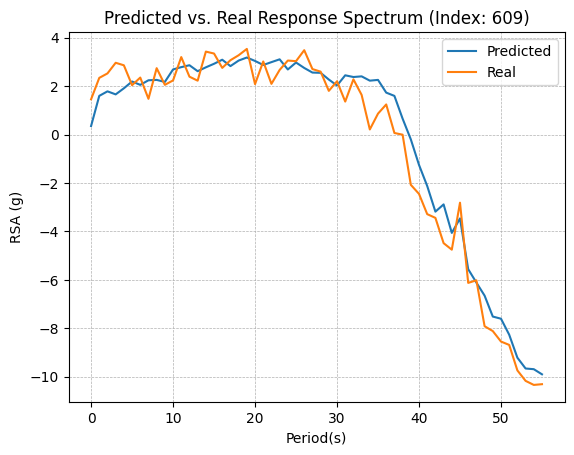

Mean Absolute Error: 0.6520
R-squared: 0.9116


In [ ]:
def plot_prediction(index, z=None):
    generator.eval()

    with torch.no_grad():  # Disable gradient calculation for inference
        if z is None:
            latent_dim = 20
            z = torch.randn(1, latent_dim).to(device)
        else:
            z = z.to(device)

        conditions = test_dataT[index].unsqueeze(0).to(torch.float32).to(device)
        real_tensor = test_outputT[index].unsqueeze(0).to(torch.float32).to(device)

        # Generate the prediction
        pred_tensor = generator(z, conditions)

        # Detach from graph and move to CPU for plotting
        pred = pred_tensor.detach().cpu().numpy().squeeze()
        real = real_tensor.detach().cpu().numpy().squeeze()

        # --- FIX: REMOVE np.exp() ---
        plt.plot(period_arr, pred, label="Predicted")
        plt.plot(period_arr, real, label="Real")
        # ---------------------------

        plt.xlabel("Period(s)")
        plt.ylabel("RSA (g)")  # The label is now correct
        plt.title(f"Predicted vs. Real Response Spectrum (Index: {index})")
        plt.legend()
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.show()

        mae = torch.mean(torch.abs(pred_tensor - real_tensor))
        print(f"Mean Absolute Error: {mae.item():.4f}")
        print(
            f"R-squared: {1 - torch.sum((test_outputT.to(torch.float32).to(device) - generator(torch.randn(len(test_dataT), 20).to(device), test_dataT.to(torch.float32).to(device))) ** 2) / torch.sum((test_outputT.to(torch.float32).to(device) - test_outputT.to(torch.float32).to(device).mean()) ** 2):.4f}"
        )

    # It's good practice to set the model back to train mode if you continue training later
    generator.train()

plot_prediction(np.random.randint(0, len(test_dataT) - 1))

In [80]:
import torch

generator.eval()

with torch.no_grad():
    # 3. Prepare all test data and generate predictions
    conditions = test_dataT.to(torch.float32).to(device)
    y_true = test_outputT.to(torch.float32).to(device)
    z = torch.randn(len(test_dataT), latent_dim).to(device)
    y_pred = generator(z, conditions)

    # 4. Calculate R-squared and print
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - y_true.mean()) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"R-squared on entire test set: {r_squared.item():.4f}")


R-squared on entire test set: 0.9121


In [72]:
torch.save(generator.state_dict(), CGAN_GENERATOR_PATH + "_l_2_penalty_incl_mse")
torch.save(discriminator.state_dict(), CGAN_DISCRIMINATOR_PATH + "_l_2_penalty_incl_mse")